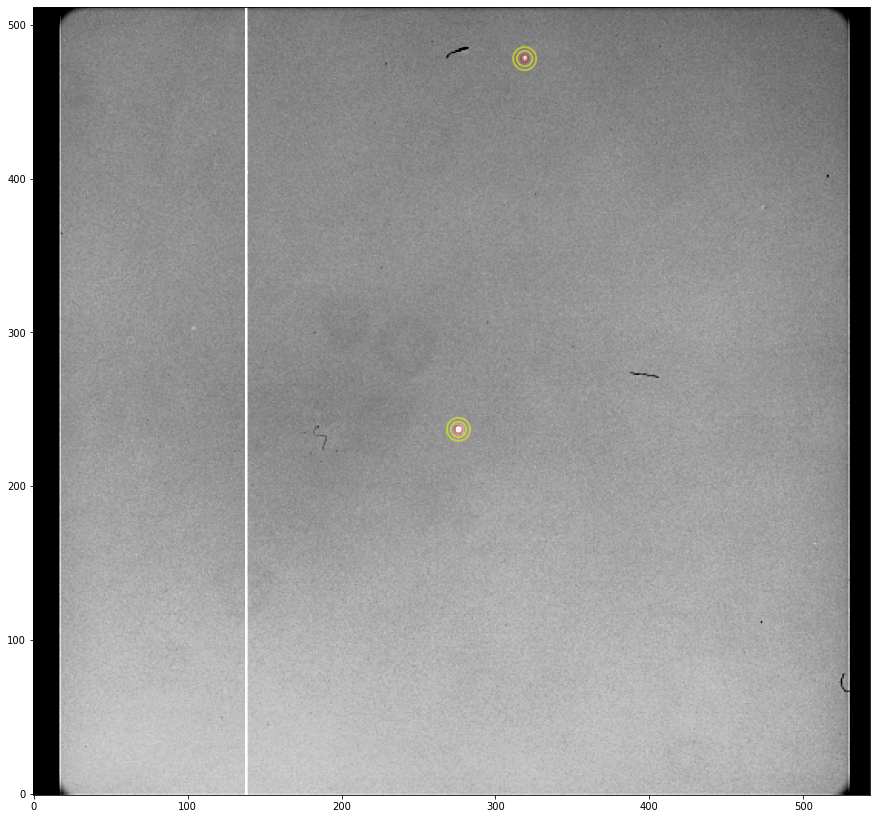

In [1]:
import numpy as np
from astropy.io import fits 
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy import wcs
from astropy.visualization import ZScaleInterval,  ImageNormalize
from photutils import CircularAperture
from photutils import CircularAnnulus
from photutils import aperture_photometry
from astropy.stats import sigma_clipped_stats
from photutils.aperture import CircularAperture, ApertureStats
import matplotlib
import matplotlib.pyplot as plt
import math
import scipy

############################ Variable Parameters #####################################
# Please feel free to change these to get an aperture you feel is appropriate 

arad = 2.5                               # aperture radius in pixels 
rin = 2*arad                           # annulus inner radius in pixels 
rout = 3*arad                         # annulus outer radius in pixels 

######################################################################################

star_pixel_ds9 = [(276,237),(319 ,478)]    
first_filenum=470
last_filenum=1178
filename = './test.' + str(first_filenum) + '.fit'
data = fits.open(filename)
pixels=star_pixel_ds9
nstars=len(pixels)
aperture = CircularAperture(pixels, r=arad)
annulus_aperture = CircularAnnulus(pixels, r_in=rin, r_out=rout)
apers = [aperture, annulus_aperture]
plt.figure(figsize = (15,15))
norm = ImageNormalize(data[0].data, interval=ZScaleInterval()) #,stretch=SqrtStretch())
plt.imshow(data[0].data, origin = 'lower', cmap = 'Greys_r', norm=norm)
aperture.plot(color='red', lw=1.5, alpha=0.5)
annulus_aperture.plot(color='yellow', lw=2, alpha=0.5)
plt.show()


In [2]:
julian_date = []
nfiles=(last_filenum-first_filenum)+1
arr=np.zeros((nstars,nfiles))
pixels = star_pixel_ds9

# Loop through all images from first_filenum to last_filenum in the current directory 
# If you do not have the images saved in the same directory as the notebook, change the path
directory = './'

for i in np.arange(nfiles): 
    # open each fits file
    pixels = [(276+(i/nfiles), 237+(i*3/nfiles)), (319+(i/nfiles), 478+(i*3/nfiles))]
    #if i > nfiles/3:
        #pixels = [(276,238),(319 ,479)]
        #if i > nfiles/2:
            #pixels = [(277,239),(320 ,480)]
            #if i > 2*nfiles/3:
                #pixels = [(277,240),(320 ,481)]
    filename = directory + 'test.' + str(i+first_filenum) + '.fit'
    data = fits.open(filename)

    # get the header and save the julian date
    hdr = data[0].header
    julian_date.append(hdr['JD'])

    # setup aperture (central and annulus) using the values we determined above
    aperture = CircularAperture(pixels, r=arad)
    annulus_aperture = CircularAnnulus(pixels, r_in=rin, r_out=rout)
    apers = [aperture, annulus_aperture]

    # extract photometry at each aperture using photutils 
    # fill in your code here ...
    napers=4
    phot_table = aperture_photometry(data[0].data, apers)
    aperstats=ApertureStats(data[0].data,aperture)

    # Save the aperture flux minus the equivalent background flux in the aperture area
    for j in np.arange(nstars):
        arr[j,i]=phot_table['aperture_sum_0'][j]-phot_table['aperture_sum_1'][j]*aperture.area/annulus_aperture.area

    # update pixels based on xcentroid,ycentroid from last     
    pixels=[(aperstats.xcentroid[0],aperstats.ycentroid[0])]
    for j in np.arange(nstars-1):
        pixels.append((aperstats.xcentroid[j+1],aperstats.ycentroid[j+1]))
        

n = 0
i = -1
truth = 1
arrtot = arr[0]/arr[1]
arrb = np.empty(0)
arrv = np.empty(0)
xb = np.empty(0)
xv = np.empty(0)
while n < nfiles: 
    if i//30 == 1:
        i = 0
        truth = not(truth)
    i += 1
    if not(n == 600 or n == 601 or n == 602 or n == 603):
        if truth:
            arrb = np.append(arrb, arrtot[n])
            xb = np.append(xb, julian_date[n])
        else:
            arrv = np.append(arrv, arrtot[n])
            xv = np.append(xv, julian_date[n])
    n+=1


n = arrv.shape[0]-1
while n > 0:
    if arrv[n] < 9:
        arrv = np.delete(arrv, n)
        xv = np.delete(xv, n)
    n-=1

def binning(arr, xarr):
    n = 0
    arr_binned = np.empty(0)
    xarr_sliced = np.empty(0)
    while n <= len(arr)-4:
        arr_binned = np.append(arr_binned, (arr[n]+arr[n+1]+arr[n+2])/3)
        xarr_sliced = np.append(xarr_sliced, xarr[n])
        n+=3
    return (arr_binned, xarr_sliced)

def plot_analytic(curve, p, t0, tau):
    curve_chi = curve.calculate_chi_squared(p, t0, tau)
    print(curve_chi)
    plt.scatter(curve.time, curve.flux, label = 'empiric', zorder=1)
    plt.plot(curve.time, curve.flux_array, label = "analytic", zorder = 3)
    plt.show()

def minimum_index(array):
    return array.index(min(array))

def minimize_t0(curve, p, tau):
    """Returns the t0 associated with the lowest Chi Squared"""
    chi_list = []
    t0_list = []
    n = curve.time[0]
    while n <= curve.time[curve.time.shape[0]-1]:
        chi_list.append(curve.calculate_chi_squared(p, n, tau))
        t0_list.append(n)
        n += 0.001
    plt.scatter(t0_list, chi_list)
    plt.title('Chi vs Central Time')
    plt.show()
    minn = minimum_index(chi_list)
    return t0_list[minn]

def minimize_tau(curve, p, t0):
    chi_list = []
    t0_list = []
    n = curve.time[0]
    while n <= curve.time[curve.time.shape[0]-1]:
        chi_list.append(curve.calculate_chi_squared(p, n, tau))
        t0_list.append(n)
        n += 0.001
    plt.scatter(t0_list, chi_list)
    plt.title('Chi vs Central Time')
    plt.show()
    minn = minimum_index(chi_list)
    return t0_list[minn]

In [3]:
class test_curve():

    def __init__(self, time, flux):        
        mean = 0
        nan_count = 0
        for element in flux:
                mean += element
        mean = mean/flux.shape[0]
        self.time = time
        self.flux = flux/mean
            
    def analytic_flux(self, t, p, t0, tau):
        def delta(p, r, z, a):
            if (r >= z + p) or (r <= z - p):
                return 0
            elif (r + z <= p):
                return 1
            else:  #all other cases
                if (z != 0) and (r!=0): #prevent div by zero errors
                    argument = (z*z - p*p + r*r) / (2.0*z*r)
                else:
                    print('Either z or r vanished. z =',z,'; and r =',r,'.')
            return (1.0/np.pi) * np.arccos(argument)


        def z(t):
            return abs(t-t0)/tau

        def a(z, p):
            return (z-p)**2
            
        def I_star(z, p):
            return (scipy.integrate.quad(I, abs(z-p), 1)[0])/(1-a(z, p))
        
        def I(r):
            u = math.sqrt(1-r**2)
            return (u)**(1/2)*2*r
        
        def flux(p, z):
            omega = 0.2
            if (z < 1-p):
                return 1 - p**2*I_star(z, p)/(4*omega)
            elif (z > 1+p):
                return 1
            elif (1+p > z) and (1+p > z):
                return  1 - (I_star(z, p)/(4*omega)) * (p**2 * np.arccos((z-1)/p) - (z-1)*math.sqrt(p**2 - (z-1)**2))
            else:
                return 1
        
        return flux(p, z(t))
    
    def analytic_flux_array(self, p, t0, tau):
        flux_array = np.array(self.time)
        n = 0
        while n < self.time.shape[0]:
            flux_array[n] = self.analytic_flux(self.time[n], p, t0, tau)
            n+=1
        self.flux_array = flux_array
        return flux_array
    
    def calculate_chi_squared(self, p, t0, tau):
        """Calculates Chi Squared given a set of parameters to model the flux"""
        chi_squared = 0
        n = 0
        self.analytic_flux_array(p, t0, tau)
        while n < self.time.shape[0]:
            if not(math.isnan(self.flux[n])):
                chi_squared += ((self.flux[n] - self.flux_array[n]))**2
            n+=1
        return chi_squared

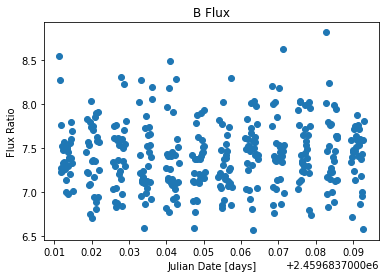

In [4]:
B = test_curve(xb, arrb)
#Bt0 = minimize_t0(B, 0.05, 0.083)
#plot_analytic(B, 0.05, Bt0, 0.083)
plt.scatter(xb, arrb)
plt.title('B Flux')
plt.xlabel('Julian Date [days]')
plt.ylabel('Flux Ratio')
plt.show()

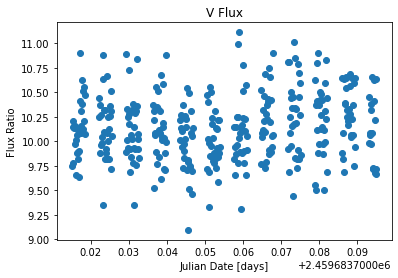

In [5]:
#binned = binning(xv, arrv)
#xv = binned[0]
#arrv = binned[1]
V = test_curve(xv, arrv)
#Vt0 = minimize_t0(V, 0.03, 0.083)
#plot_analytic(V, 0.03, Vt0, 0.083)
plt.scatter(xv, arrv)
plt.title('V Flux')
plt.xlabel('Julian Date [days]')
plt.ylabel('Flux Ratio')
plt.show()

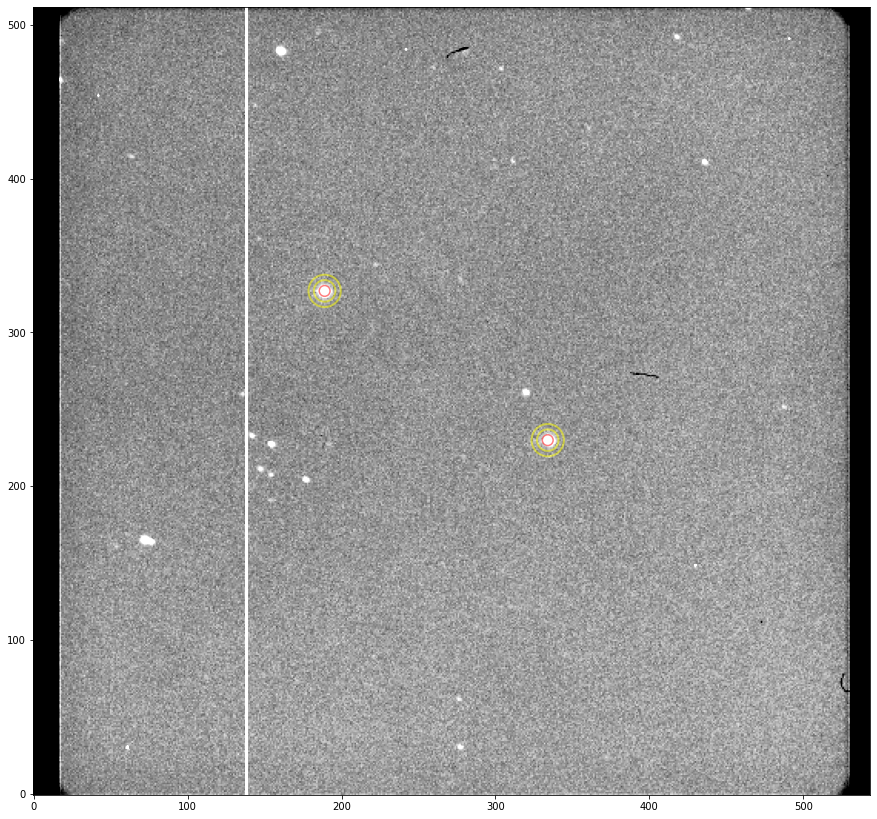

In [6]:

arad = 3.5
rin = 2*arad                     
rout = 3*arad     

star_pixel_ds9 = [(334,230),(189 ,327)]    
first_filenum=4
last_filenum=470
filename = './Qatar2b.' + str(last_filenum) + '.fit'
data = fits.open(filename)
pixels=star_pixel_ds9
nstars=len(pixels)
aperture = CircularAperture(pixels, r=arad)
annulus_aperture = CircularAnnulus(pixels, r_in=rin, r_out=rout)
apers = [aperture, annulus_aperture]
plt.figure(figsize = (15,15))
norm = ImageNormalize(data[0].data, interval=ZScaleInterval()) #,stretch=SqrtStretch())
plt.imshow(data[0].data, origin = 'lower', cmap = 'Greys_r', norm=norm)
aperture.plot(color='red', lw=1.5, alpha=0.5)
annulus_aperture.plot(color='yellow', lw=2, alpha=0.5)
plt.show()

In [7]:
filenames = np.empty(0)
n = 3
while n < last_filenum:
    if n <=9:
        filenames = np.append(filenames, './Qatar2b.00'+str(n)+'.fit')
    elif n <=99:
        filenames = np.append(filenames, './Qatar2b.0'+str(n)+'.fit')
    elif n < 512:
        filenames = np.append(filenames, './Qatar2b.'+str(n)+'.fit')
    n+=1

In [8]:
julian_date = []
nfiles=(filenames.shape[0])+1
arr=np.zeros((nstars,nfiles))
pixels = star_pixel_ds9

# Loop through all images from first_filenum to last_filenum in the current directory 
# If you do not have the images saved in the same directory as the notebook, change the path
directory = './'

for i in np.arange(nfiles): 
    # open each fits file
    pixels = [(334, 227+(i*3/nfiles)), (189, 324+(i*3/nfiles))]
    filename = filenames[i-1]
    data = fits.open(filename)

    # get the header and save the julian date
    hdr = data[0].header
    julian_date.append(hdr['JD'])

    # setup aperture (central and annulus) using the values we determined above
    aperture = CircularAperture(pixels, r=arad)
    annulus_aperture = CircularAnnulus(pixels, r_in=rin, r_out=rout)
    apers = [aperture, annulus_aperture]

    # extract photometry at each aperture using photutils 
    # fill in your code here ...
    napers=4
    phot_table = aperture_photometry(data[0].data, apers)
    aperstats=ApertureStats(data[0].data,aperture)

    # Save the aperture flux minus the equivalent background flux in the aperture area
    for j in np.arange(nstars):
        arr[j,i]=phot_table['aperture_sum_0'][j]-phot_table['aperture_sum_1'][j]*aperture.area/annulus_aperture.area

    # update pixels based on xcentroid,ycentroid from last     
    pixels=[(aperstats.xcentroid[0],aperstats.ycentroid[0])]
    for j in np.arange(nstars-1):
        pixels.append((aperstats.xcentroid[j+1],aperstats.ycentroid[j+1]))

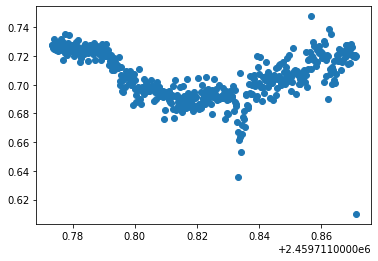

In [9]:
flux = arr[0]/arr[1]
plt.xlabel('Time [Days]')
plt.ylabel('Flux Ratio with')
plt.scatter(julian_date, flux)
plt.show()

In [10]:
print(pixels)

[(334.34470201066716, 230.01763073463113), (188.9364864042296, 326.8860337915982)]


In [11]:
print(xv[6])

2459683.71579
